# Test Detic (cleanup code & testing)

- Refactor code
- Check functionalities

---
- 2022-05-29 jkang

In [1]:
# Visualization
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# System
import os
import sys
import numpy as np
import json
from glob import glob

# DL
import torch
import clip

# Detectron
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger(output='./notebook.log')

# Detectron libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic
sys.path.insert(0, 'third_party/CenterNet2')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test
from detic.modeling.text.text_encoder import CLIPTEXT # , build_text_encoder

## Settings

In [2]:
ENV = 'detic'

IMAGE_FILE = 'desk.jpg'
CACHE_DIR = 'cached'
DRAWING_DIR = 'child_drawings'

GPU_ID = '-1'  # -1 for none

In [3]:
# Check environment
py_path = !which python
assert ENV in py_path[0], 'Activate "detic" environment'

In [4]:
# Set gpu
os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
print(GPU_ID)

-1


In [5]:
# Set cache dir
os.environ['TORCH_HOME'] = CACHE_DIR
# Download clip model into cached dir
pretrained_model, _ = clip.load("ViT-B/32", device='cpu', download_root=CACHE_DIR)

In [6]:
# Load images
image_files = glob(os.path.join(DRAWING_DIR, '*.png'))
print(len(image_files))

11


In [ ]:
%%capture
# Setup models
# - detectron2
# - centernet
# - detic
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)

cfg.merge_from_file('configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml')
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5            # Set model threshold
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True      # For better visualization purpose
#cfg.MODEL.DEVICE = 'cpu'                               # Uncomment this to cpu-only mode
predictor = DefaultPredictor(cfg)

clear_output()

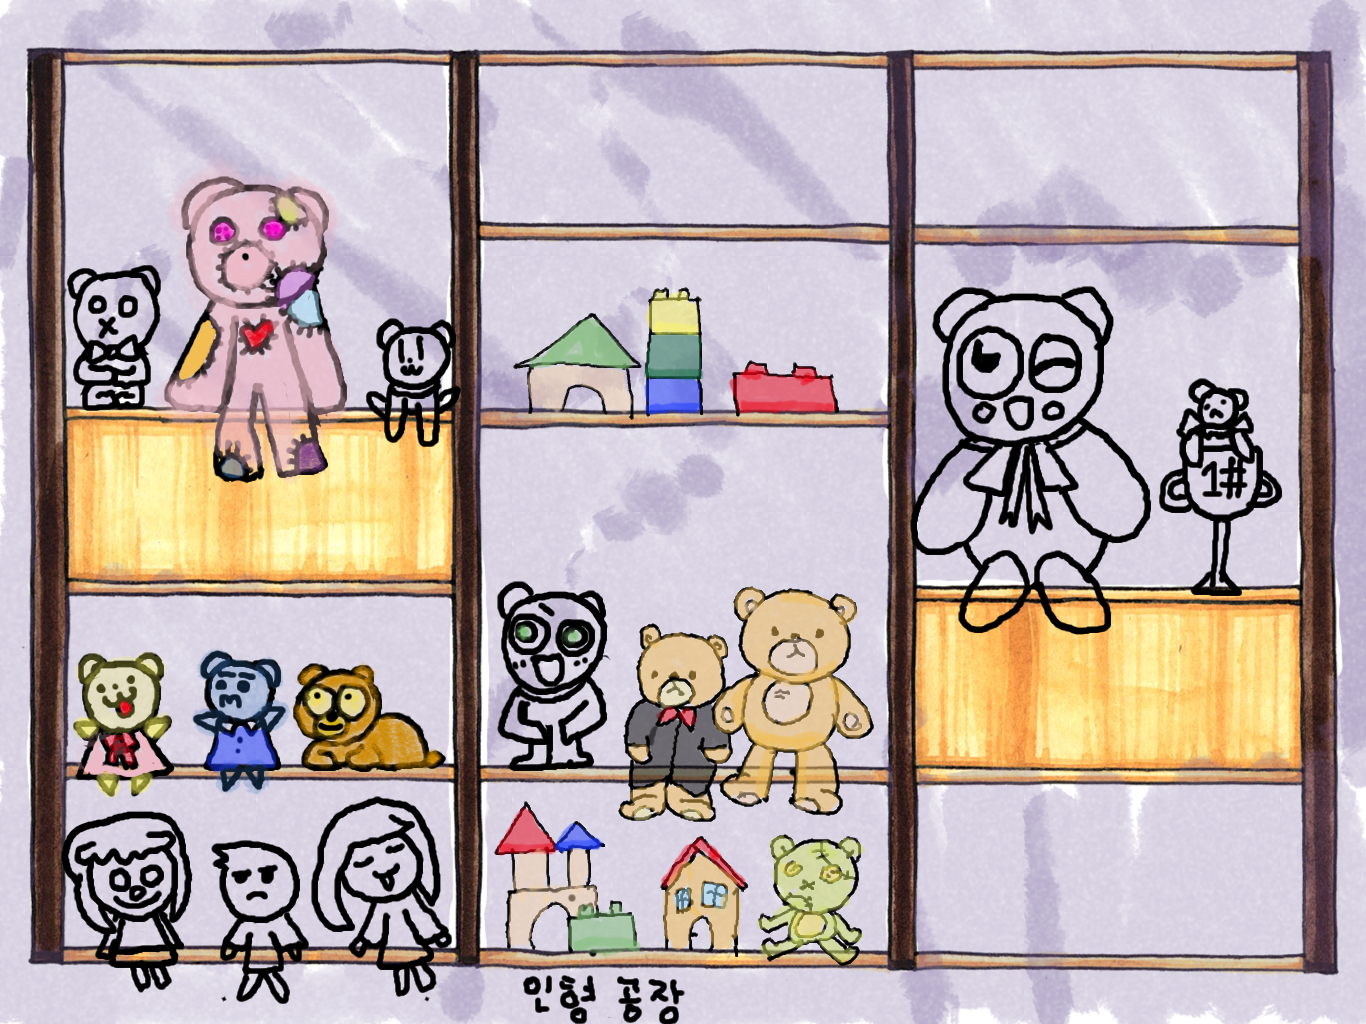

In [8]:
# img_pil = Image.open(IMAGE_FILE).convert('RGB')
img_pil = Image.open(image_files[0]).convert('RGB')

img_pil

In [9]:
# Setup the model's vocabulary using build-in datasets
BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

# from detectron2.data import MetadataCatalog

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


### Check Detectron output

In [10]:
def infer(model, img_array, metadata):
    outputs = model(img_array)
    v = Visualizer(img_array[:,:,::-1], metadata)
    out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    return out, outputs

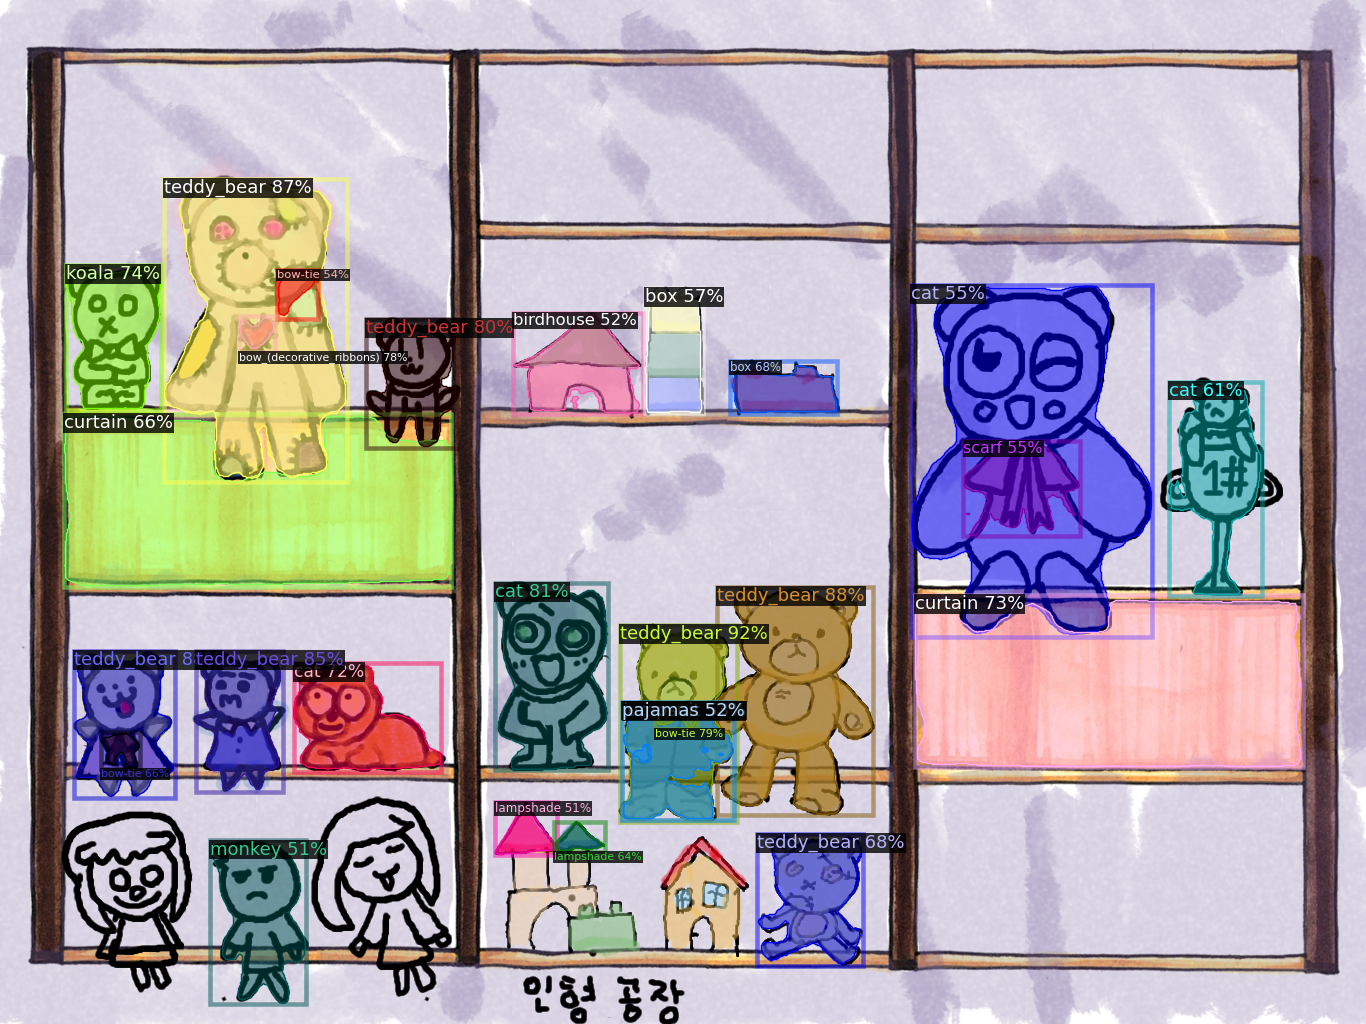

In [11]:
img_out, outputs = infer(predictor, np.asarray(img_pil), metadata)

Image.fromarray(img_out.get_image()[:,:,::-1])

### Check Detic output

In [12]:
def build_text_encoder(pretrain=True):
    # Taken from detic.modeling.text.text_encoder.build_text_encoder
    # to set cache_dir
    text_encoder = CLIPTEXT()
    if pretrain:
        import clip
        pretrained_model, _ = clip.load("ViT-B/32", device='cpu', download_root=CACHE_DIR)
        state_dict = pretrained_model.state_dict()
        to_delete_keys = ["logit_scale", "input_resolution", \
        "context_length", "vocab_size"] + \
            [k for k in state_dict.keys() if k.startswith('visual.')]
        for k in to_delete_keys:
            if k in state_dict:
                del state_dict[k]
        print('Loading pretrained CLIP')
        text_encoder.load_state_dict(state_dict)
    # import pdb; pdb.set_trace()
    return text_encoder

def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb

In [15]:
vocabulary = 'custom'
MetadataCatalog.clear()
metadata = MetadataCatalog.get("__unused")
# metadata.thing_classes = ['headphone', 'webcam', 'paper', 'coffee'] # Change here to try your own vocabularies!
metadata.thing_classes = ['a cute teddy bear', 'bear'] # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

Loading pretrained CLIP


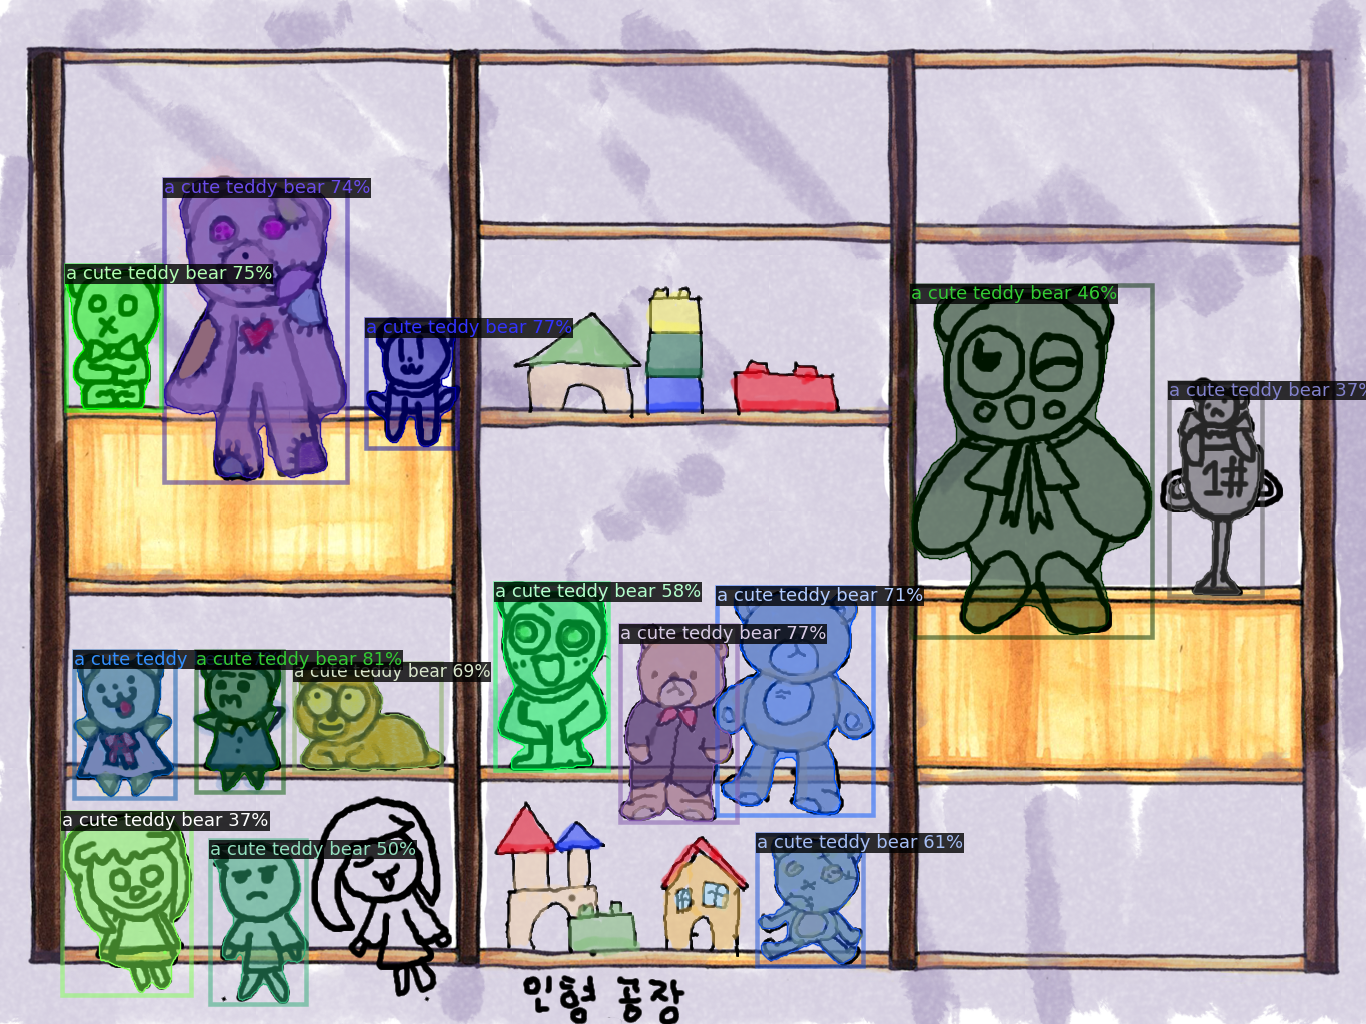

In [16]:
img_out, outputs = infer(predictor, np.asarray(img_pil), metadata)
Image.fromarray(img_out.get_image()[:,:,::-1])